In [ ]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import tensorflow_hub as hub
import gdown
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.15.0
Eager mode:  True
Hub version:  0.16.1
GPU is NOT AVAILABLE


In [ ]:
url = 'https://drive.google.com/uc?id=1SpPZg-_scagsSScNEi-gt06tEgM4S-EK'

output_path = '/content/all_tickets_processed.csv'

gdown.download(url, output_path, quiet=False)

data = pd.read_csv(output_path)

Downloading...
From: https://drive.google.com/uc?id=1SpPZg-_scagsSScNEi-gt06tEgM4S-EK
To: /content/all_tickets_processed.csv
100%|██████████| 14.6M/14.6M [00:00<00:00, 36.5MB/s]


In [ ]:
df = pd.read_csv('/content/all_tickets_processed.csv')

In [ ]:
# # shuffle the DataFrame rows
# df = df.sample(frac=1, random_state=28)

# df.head()

,Document,Topic_group
40715,federation service seems to have changed sent ...,Hardware
2292,mail dear please create possibility mails whic...,Miscellaneous
22204,creation of a mail called am team wednesday pm...,Miscellaneous
43308,password reset for tine hello there let ask me...,Access
10378,access to confluence wednesday pm confluence d...,Access


In [ ]:
df['Topic_group'].value_counts()



Topic_group
Hardware                 13617
HR Support               10915
Access                    7125
Miscellaneous             7060
Storage                   2777
Purchase                  2464
Internal Project          2119
Administrative rights     1760
Name: count, dtype: int64

In [ ]:
df['Topic_group'].unique()

array(['Hardware', 'Access', 'Miscellaneous', 'HR Support', 'Purchase',
       'Administrative rights', 'Storage', 'Internal Project'],
      dtype=object)

<Axes: xlabel='Topic_group'>

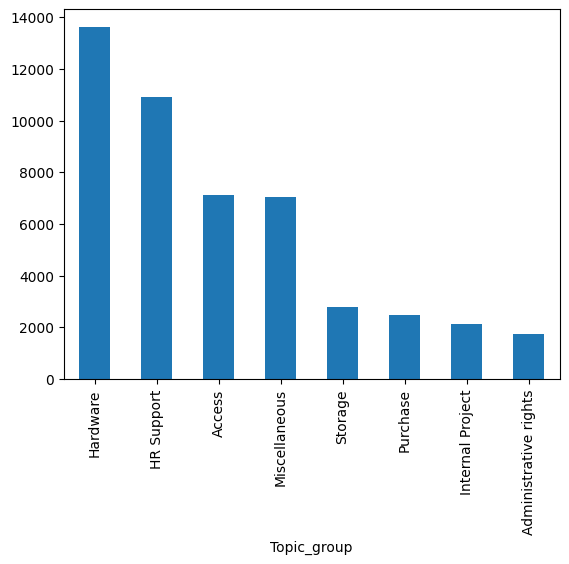

In [ ]:
df['Topic_group'].value_counts().plot(kind='bar')


In [ ]:
# Documental Length Analysis
print('Average number of characters:', df['Document'].apply(len).mean())
print('Average number of words:', df['Document'].apply(lambda x: len(x.split())).mean())

Average number of characters: 291.8812634571566
Average number of words: 43.597340970378575


To balance out the dataset, downsample the majority classes (Hardware, HR Support, Access, Miscellaneous) such that there are only 5000 rows each.

In [ ]:
# Get the indices for each category
hardware_indices = df[df['Topic_group'] == 'Hardware'].index
hr_support_indices = df[df['Topic_group'] == 'HR Support'].index
access_indices = df[df['Topic_group'] == 'Access'].index
miscellaneous_indices = df[df['Topic_group'] == 'Miscellaneous'].index

# Create a list of indices to drop
indices_to_drop = random.sample(list(hardware_indices), len(hardware_indices) - 5000) + \
                  random.sample(list(hr_support_indices), len(hr_support_indices) - 5000) + \
                  random.sample(list(access_indices), len(access_indices) - 5000) + \
                  random.sample(list(miscellaneous_indices), len(miscellaneous_indices) - 5000)

# Drop the rows
tickets_df_downsample = df.drop(indices_to_drop)

# Check the number of rows for each category
print(tickets_df_downsample.shape)
print("Hardware count:", tickets_df_downsample[tickets_df_downsample['Topic_group'] == 'Hardware'].shape[0])
print("HR Support count:", tickets_df_downsample[tickets_df_downsample['Topic_group'] == 'HR Support'].shape[0])
print("Access count:", tickets_df_downsample[tickets_df_downsample['Topic_group'] == 'Access'].shape[0])
print("Miscellaneous count:", tickets_df_downsample[tickets_df_downsample['Topic_group'] == 'Miscellaneous'].shape[0])



(29120, 2)
Hardware count: 5000
HR Support count: 5000
Access count: 5000
Miscellaneous count: 5000


<Axes: xlabel='Topic_group'>

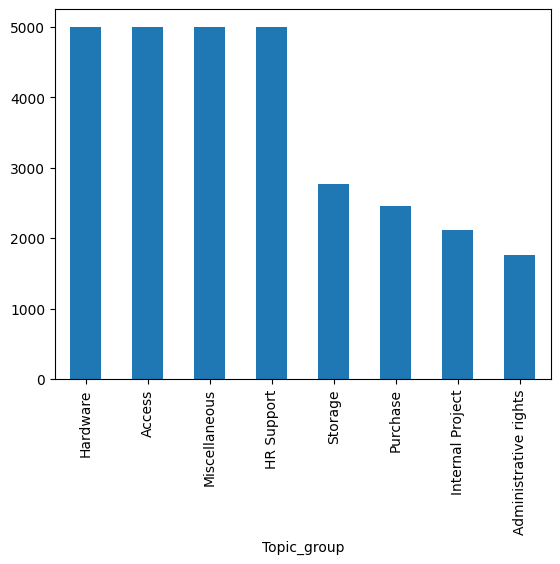

In [ ]:
tickets_df_downsample['Topic_group'].value_counts().plot(kind='bar')

In [ ]:
import re
def cleanTxt(text):
    text = re.sub(r'@\w+|#\w+', '', text) #Removing @mentions
    text = re.sub('#', '', text) # Removing '#' hash tag
    text = re.sub('RT[\s]+', '', text) # Removing RT
    text = re.sub('\w+:\/\/\S+', '', text) # Removing hyperlink
    #remove punctuation
    text = re.sub('[^a-zA-Z]', ' ', text)
    text.lower()
    return text

In [ ]:
tickets_df_downsample['Cleaned_Document'] = tickets_df_downsample['Document'].apply(lambda x: cleanTxt(x))


In [ ]:
tickets_df_downsample['Cleaned_Document'] = tickets_df_downsample['Cleaned_Document'].apply(lambda x: x.lower())
tickets_df_downsample


,Document,Topic_group,Cleaned_Document
0,connection with icon icon dear please setup ic...,Hardware,connection with icon icon dear please setup ic...
1,work experience user work experience user hi w...,Access,work experience user work experience user hi w...
2,requesting for meeting requesting meeting hi p...,Hardware,requesting for meeting requesting meeting hi p...
4,mail verification warning hi has got attached ...,Miscellaneous,mail verification warning hi has got attached ...
6,prod servers tunneling prod tunneling va la tu...,Hardware,prod servers tunneling prod tunneling va la tu...
...,...,...,...
47829,sensitive information access sent wednesday ju...,Storage,sensitive information access sent wednesday ju...
47831,cannot on outlook account from laptop cannot l...,Administrative rights,cannot on outlook account from laptop cannot l...
47832,git space for a project issues with adding use...,Access,git space for a project issues with adding use...
47833,error sent july error hi guys can you help out...,Miscellaneous,error sent july error hi guys can you help out...


In [ ]:
import nltk
# download all

nltk.download('all')

In [ ]:
from nltk.corpus import stopwords

stop = stopwords.words('english')

def remove_stopwords(text):
    text = [word for word in text.split() if word not in stop]
    return " ".join(text)

In [ ]:
# stopword removal

tickets_df_downsample['Cleaned_Document'] = tickets_df_downsample['Cleaned_Document'].apply(lambda x: remove_stopwords(x))

In [ ]:
# function to lemmitize Topic_group column

def lemmatization(text):
    text = [lemmatizer.lemmatize(word) for word in text.split()]
    return " ".join(text)

In [ ]:
# lemmatization
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

tickets_df_downsample['Cleaned_Document'] = tickets_df_downsample['Cleaned_Document'].apply(lambda x: lemmatization(x))




In [ ]:
# Assuming 'df' is your DataFrame and 'columns_to_drop' is a list of column names you want to drop
columns_to_drop = ['Encoded_Labels']

# Drop the specified columns
tickets_df_downsample.drop(columns=columns_to_drop, inplace=True)

tickets_df_downsample

,Topic_group,Cleaned_Document
0,Hardware,connection icon icon dear please setup icon pe...
1,Access,work experience user work experience user hi w...
2,Hardware,requesting meeting requesting meeting hi pleas...
4,Miscellaneous,mail verification warning hi got attached plea...
6,Hardware,prod server tunneling prod tunneling va la tun...
...,...,...
47829,Storage,sensitive information access sent wednesday ju...
47831,Administrative rights,cannot outlook account laptop cannot laptop sa...
47832,Access,git space project issue adding user sent tuesd...
47833,Miscellaneous,error sent july error hi guy help error appear...


<Axes: xlabel='Topic_group'>

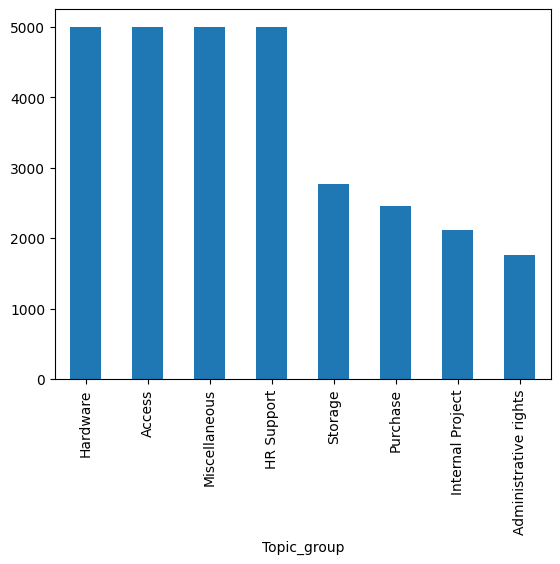

In [ ]:
tickets_df_downsample['Topic_group'].value_counts().plot(kind='bar')

In [ ]:
# Define a dictionary to map labels to numerical values
label_mapping = {
    'Access': 0,
    'HR Support': 1,
    'Hardware': 2,
    'Miscellaneous': 3,
    'Storage': 4,
    'Purchase': 5,
    'Internal Project': 6,
    'Administrative rights': 7
}

# Map the labels to their corresponding numerical values
tickets_df_downsample['Encoded_Labels'] = tickets_df_downsample['Topic_group'].map(label_mapping)

tickets_df_downsample

,Topic_group,Cleaned_Document,Encoded_Labels
0,Hardware,connection icon icon dear please setup icon pe...,2
1,Access,work experience user work experience user hi w...,0
2,Hardware,requesting meeting requesting meeting hi pleas...,2
4,Miscellaneous,mail verification warning hi got attached plea...,3
6,Hardware,prod server tunneling prod tunneling va la tun...,2
...,...,...,...
47829,Storage,sensitive information access sent wednesday ju...,4
47831,Administrative rights,cannot outlook account laptop cannot laptop sa...,7
47832,Access,git space project issue adding user sent tuesd...,0
47833,Miscellaneous,error sent july error hi guy help error appear...,3


In [ ]:
y=tickets_df_downsample['Topic_group']
X = tickets_df_downsample['Cleaned_Document']

y

0                     Hardware
1                       Access
2                     Hardware
4                Miscellaneous
6                     Hardware
                 ...          
47829                  Storage
47831    Administrative rights
47832                   Access
47833            Miscellaneous
47835               HR Support
Name: Topic_group, Length: 29120, dtype: object

In [ ]:
le=LabelEncoder()
y=le.fit_transform(y)
le.classes_

array(['Access', 'Administrative rights', 'HR Support', 'Hardware',
       'Internal Project', 'Miscellaneous', 'Purchase', 'Storage'],
      dtype=object)

In [ ]:
from sklearn.model_selection import train_test_split


# Split the dataset into training and test sets (80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_test
# Print the shapes of the training and test sets
print("Training set - Features:", X_train.shape, " Labels:", y_train.shape)
print("Test set - Features:", X_test.shape, " Labels:", y_test.shape)


Training set - Features: (23296,)  Labels: (23296,)
Test set - Features: (5824,)  Labels: (5824,)


In [ ]:
x_val = X_train[:3000]
partial_x_train = X_train[20000:]

y_val = y_train[:3000]
partial_y_train = y_train[20000:]

In [ ]:
# model = "https://tfhub.dev/google/nnlm-en-dim50/2"
# hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)
# hub_layer(X[:3])

In [ ]:
model = "https://tfhub.dev/google/nnlm-en-dim50-with-normalization/2"
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)
hub_layer(X[:3])

In [ ]:
# model = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"
# hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)
# hub_layer(train_examples[:3])

In [ ]:
# # Define the model
# model = tf.keras.Sequential([
#     hub_layer,
#     tf.keras.layers.Dense(16, activation='relu'),
#     tf.keras.layers.Dense(3, activation='softmax')  # Change num_classes to the number of classes in your dataset
# ])

In [ ]:
model = tf.keras.Sequential([
    hub_layer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),  # Dropout layer
    tf.keras.layers.Dense(8, activation='softmax')
])


In [ ]:
# # Compile the model
# model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',  # Use sparse categorical crossentropy for multi-class classification
#               metrics=['accuracy'])  # Add additional metrics if needed

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [ ]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/40
 9/13 [===================>..........] - ETA: 6s - loss: 0.3353 - accuracy: 0.9136

In [ ]:
# from transformers import BertTokenizer, TFBertForSequenceClassification
# from sklearn.metrics import accuracy_score

# # Load the pre-trained BERT tokenizer
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# # Disable AutoGraph for a specific function or code block
# @tf.autograph.experimental.do_not_convert
# def function_with_for_else():
#     for item in some_list:
#         if condition(item):
#             # Handle the condition
#             break
#     else:
#         # Execute this block if the loop completes without encountering a 'break'
#         pass


In [ ]:
# # Tokenize input text data
# def tokenize_text(text):
#     return tokenizer.encode_plus(
#         text,
#         add_special_tokens=True,
#         max_length=128,
#         padding='max_length',
#         return_attention_mask=True,
#         return_token_type_ids=False,
#         truncation=True,
#         return_tensors='tf'
#     )

# # Tokenize training and test data
# X_train_tokenized = [tokenize_text(text) for text in X_train]

# X_test_tokenized = [tokenize_text(text) for text in X_test]


In [ ]:
# # Convert labels to TensorFlow tensors
# y_train = tf.convert_to_tensor(y_train)
# y_test = tf.convert_to_tensor(y_test)

# # Convert tokenized input data to TensorFlow tensors
# X_train_input_ids = tf.concat([x['input_ids'] for x in X_train_tokenized], axis=0)
# X_train_attention_masks = tf.concat([x['attention_mask'] for x in X_train_tokenized], axis=0)
# X_test_input_ids = tf.concat([x['input_ids'] for x in X_test_tokenized], axis=0)
# X_test_attention_masks = tf.concat([x['attention_mask'] for x in X_test_tokenized], axis=0)


In [ ]:
# # Load pre-trained BERT model for sequence classification
# model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')


# # Configure output layer for three labels
# num_classes = 3  # Number of classification categories
# output_layer = tf.keras.layers.Dense(num_classes, activation='softmax')

# # Compile the model
# optimizer = 'adam'
# loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
# model.compile(optimizer=optimizer, loss=loss, metrics=[metric])


In [ ]:
# from transformers import TFBertForSequenceClassification

# # Load pre-trained BERT model for sequence classification
# model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)  # Specify num_labels=3

# # Compile the model
# optimizer = 'adam'
# loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)  # Set from_logits=True for BERT's output
# metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
# model.compile(optimizer=optimizer, loss=loss, metrics=[metric])


In [ ]:
# # Train the model
# history = model.fit(
#     [X_train_input_ids, X_train_attention_masks],
#     y_train,
#     epochs=3,
#     batch_size=50,
#     validation_data=([X_test_input_ids, X_test_attention_masks], y_test)
# )



In [ ]:
# # Evaluate the model
# predictions = model.predict([X_test_input_ids, X_test_attention_masks])
# y_pred = tf.argmax(predictions.logits, axis=1)
# accuracy = accuracy_score(y_test, y_pred)
# print("Test Accuracy:", accuracy)


In [ ]:
# loss, accuracy = model.evaluate([X_test_input_ids, X_test_attention_masks], y_test)
# print("Test Loss:", loss)
# print("Test Accuracy:", accuracy)

In [ ]:
results = model.evaluate(X_test, y_test)

print(results)

182/182 [==============================] - 33s 181ms/step - loss: 0.6668 - accuracy: 0.7984
[0.6667777895927429, 0.7984203100204468]


In [ ]:
results_pred = model.predict(X_test)
classes_x=np.argmax(results_pred ,axis=1)

182/182 [==============================] - 33s 182ms/step


In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

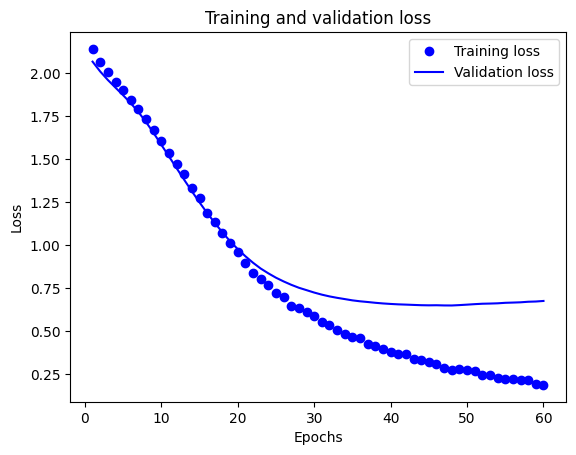

In [ ]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

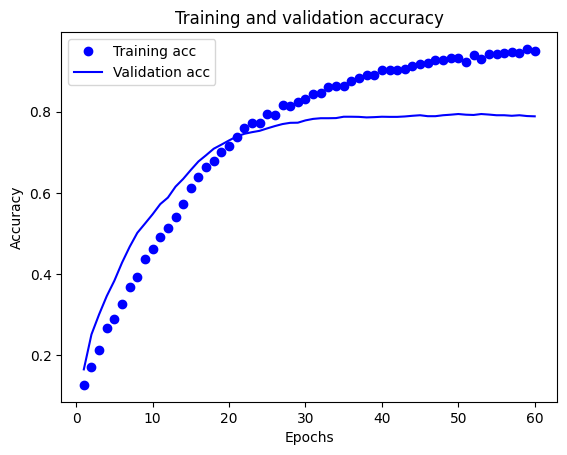

In [ ]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()